In [1]:
import numpy as np

import torch
from torch import nn

%matplotlib inline
from matplotlib import pyplot as plt

import cv2
import numpy as np
from pathlib import Path
from PIL import Image

import time
import json

In [13]:
current_folder = Path.cwd()
tesi_folder = Path('~/Scuola/now').expanduser()

In [15]:
with open(tesi_folder / 'experiments.json', 'r') as reader:
    experiments = json.load(reader)

In [16]:
n_epochs = 50
iter_per_epoch = 149
iters_done = np.linspace(iter_per_epoch, iter_per_epoch * n_epochs, n_epochs)

In [20]:
def plot_metrics(axis, metrics, iters):
    if 'train' in metrics:
        done = len(metrics['train'])
        epochs = list(range(1, done + 1))
        axis.plot(
            epochs, np.float32(metrics['train']) / 4.0, label='average on TRAIN set (S1, S6, S7, S8)', color='red'
        )
    
    if 'eval' in metrics:
        done = len(metrics['eval'])
        epochs = list(range(1, done + 1))
        axis.plot(
            epochs, np.float32(metrics['eval']) / 2.0, label='average on EVAL set (S9, S11)', color='green'
        )

In [18]:
def get_figsize(n_rows, n_cols):
    row_size = 4  # heigth
    column_size = 20  # width

    return (n_cols * column_size, n_rows * row_size)


def get_figa(n_rows, n_cols):
    fig, ax = plt.subplots(n_rows, n_cols, figsize=get_figsize(n_rows, n_cols))
    return fig, ax

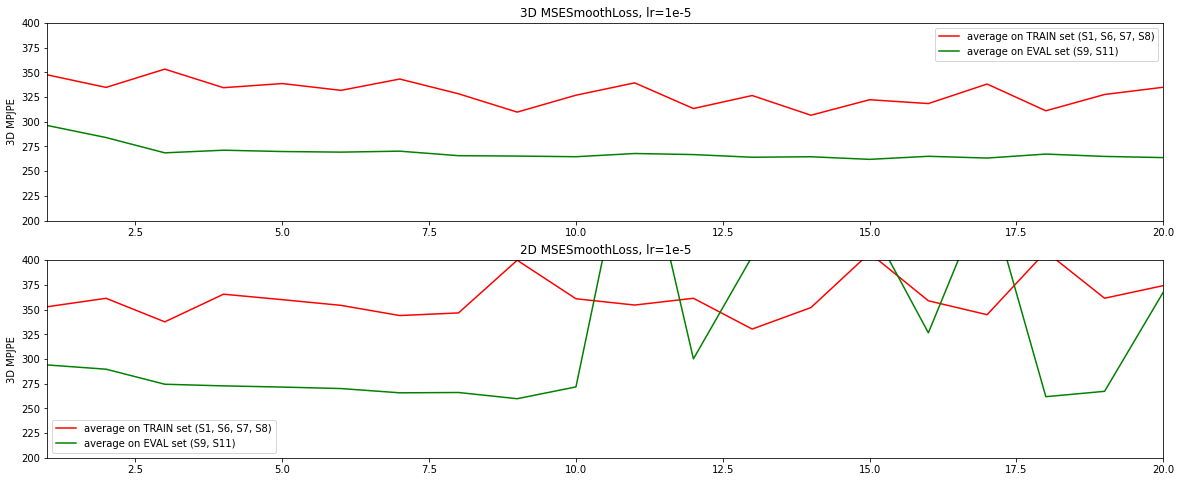

In [21]:
fig, ax = get_figa(2, 1)

for axis, metrics in zip(
        ax.ravel(),
        [experiments['04_08_12_07'], experiments['04_08_12_49']]
    ):
    plot_metrics(axis, metrics, iters_done)

    axis.set_ylim([200, 400])
    axis.set_xlim([1, 20])

    axis.set_ylabel('3D MPJPE')
    # axis.set_xlabel('epoch')
    
    axis.set_title(metrics['title'])

    axis.legend()

In [49]:
class MiniMonValue:
    def __init__(self):
        self.runtime_sum = np.float32(0)
        self.runtime_min = np.float32('inf')
        self.runtime_max = -np.float32('inf')
        self.num = 0
        
    def apply(self, value):
        self.runtime_sum += value;
        self.runtime_min = min(self.runtime_min, value)
        self.runtime_max = max(self.runtime_max, value)
        self.num += 1
    
    def get_avg(self):
        return self.runtime_sum / self.num
    
    def get_min(self):
        return self.runtime_min
    
    def get_max(self):
        return self.runtime_max
    
    def get_stats(self):
        return {
            'min': self.get_min(),
            'max': self.get_max(),
            'avg': self.get_avg(),
            'count': self.num
        }
    

class MiniMon:
    def __init__(self):
        self.store = {}  # str -> MiniMonValue
        self.entries = []  # LIFO
        
    def get_time_now(self):
        return time.time()
    
    def enter(self):
        self.entries.append(self.get_time_now())
        
    def leave(self, checkpoint_name):
        last_time = self.entries.pop()
        
        if checkpoint_name not in self.store:
            self.store[checkpoint_name] = MiniMonValue()
            
        self.store[checkpoint_name].apply(self.get_time_now() - last_time)
        
    def get_stats(self):
        return {
            checkpoint: info.get_stats()
            for checkpoint, info in self.store.items()
        }
        
    def print_stats(self, as_minutes=False):
        f_out='{:>20} x {:10d} ~ {:10.1f} [{:10.1f}, {:10.1f}]'
        
        for checkpoint, info in sorted(self.store.items(), key=lambda x:x[1].get_avg()):
            if info.num > 1:
                print(f_out.format(
                    checkpoint[-20:],
                    info.num,
                    info.get_avg() / (60.0 if as_minutes else 1.0),
                    info.get_min() / (60.0 if as_minutes else 1.0),
                    info.get_max() / (60.0 if as_minutes else 1.0)
                ))
            else:  # single call
                print('{:>20}   {:>10} ~ {:10.1f}'.format(
                    checkpoint[-20:],
                    '',
                    info.get_avg() / (60.0 if as_minutes else 1.0)
                ))
                
        if as_minutes:
            print('    all times are in minutes')
        else:
            print('    all times are in seconds')

In [51]:
m = MiniMon()

def f():
    m.enter()
    
    m.enter()
    for _ in range(2):
        m.enter()
        time.sleep(np.random.random())
        m.leave('sleep 1')
    m.leave('primo')
    
    m.enter()
    for _ in range(3):
        m.enter()
        time.sleep(1)
        m.leave('sleep 2')
    m.leave('secondo')
    
    m.leave('f')
    
f()
m.print_stats(as_minutes=False)

             sleep 1 x          2 ~        0.3 [       0.1,        0.4]
               primo              ~        0.5
             sleep 2 x          3 ~        1.0 [       1.0,        1.0]
             secondo              ~        3.0
                   f              ~        3.5
    all times are in seconds


In [8]:
def normalize_transformation(feature_range):
    def _f(x):
        shape = x.shape
        
        m = x.min()
        M = x.max()
        
        x = (x - m) / (M - m) * (feature_range[1] - feature_range[0]) + feature_range[0]
        
        x = x.reshape(shape)  # original size
        return x

    return _f